<a href="https://colab.research.google.com/github/chenwh0/ARC-AGI-hackathon/blob/main/dream_coder_adaptation_needs_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, json, math, random, time, itertools, glob, copy, functools, statistics
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import List, Tuple, Callable, Any, Dict, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_tasks(folder):
    tasks = []
    for p in sorted(glob.glob(os.path.join(folder, "*.json"))):
        with open(p, "r") as f:
            t = json.load(f)
        tasks.append((os.path.basename(p), t))
    return tasks


DATA_ROOT = "data"  # change to your path
TRAIN_DIR = os.path.join(DATA_ROOT, "training")
EVAL_DIR  = os.path.join(DATA_ROOT, "evaluation")

train_tasks = load_tasks(TRAIN_DIR)
eval_tasks  = load_tasks(EVAL_DIR)

print(len(train_tasks), len(eval_tasks))

1000 120


In [ ]:
train_tasks[0]

('00576224.json',
 {'train': [{'input': [[7, 9], [4, 3]],
    'output': [[7, 9, 7, 9, 7, 9],
     [4, 3, 4, 3, 4, 3],
     [9, 7, 9, 7, 9, 7],
     [3, 4, 3, 4, 3, 4],
     [7, 9, 7, 9, 7, 9],
     [4, 3, 4, 3, 4, 3]]},
   {'input': [[8, 6], [6, 4]],
    'output': [[8, 6, 8, 6, 8, 6],
     [6, 4, 6, 4, 6, 4],
     [6, 8, 6, 8, 6, 8],
     [4, 6, 4, 6, 4, 6],
     [8, 6, 8, 6, 8, 6],
     [6, 4, 6, 4, 6, 4]]}],
  'test': [{'input': [[3, 2], [7, 8]],
    'output': [[3, 2, 3, 2, 3, 2],
     [7, 8, 7, 8, 7, 8],
     [2, 3, 2, 3, 2, 3],
     [8, 7, 8, 7, 8, 7],
     [3, 2, 3, 2, 3, 2],
     [7, 8, 7, 8, 7, 8]]}]})

In [ ]:
eval_tasks[0]

('0934a4d8.json',
 {'train': [{'input': [[3,
      5,
      3,
      3,
      6,
      6,
      5,
      4,
      1,
      4,
      9,
      9,
      4,
      3,
      9,
      9,
      9,
      9,
      3,
      4,
      9,
      9,
      4,
      1,
      4,
      5,
      6,
      6,
      3,
      3],
     [5,
      3,
      3,
      3,
      6,
      6,
      4,
      5,
      4,
      1,
      9,
      9,
      3,
      4,
      9,
      1,
      1,
      9,
      4,
      3,
      9,
      9,
      1,
      4,
      5,
      4,
      6,
      6,
      3,
      3],
     [1,
      1,
      3,
      5,
      5,
      4,
      6,
      6,
      9,
      1,
      1,
      4,
      9,
      9,
      4,
      5,
      5,
      4,
      9,
      9,
      4,
      1,
      1,
      9,
      6,
      6,
      4,
      5,
      5,
      3],
     [1,
      1,
      5,
      3,
      4,
      5,
      6,
      6,
      1,
      9,
      4,
      1,
      9,
      1,
      4,
      4,
      4

In [ ]:
# standardize on array for grids, helpers keep code readable
def to_np(grid):
    return np.array(grid, dtype=np.int64)

def same_grid(a, b):
    """Exact equality (shape + element-wise). ARC requires exact matches."""
    return a.shape == b.shape and np.array_equal(a, b)

def pad_to(g, H, W, fill=0):
    """Pad/crop grid to HxW for neural encoder input."""
    r, c = g.shape
    out = np.full((H, W), fill, dtype=np.int64)
    out[:min(H,r), :min(W,c)] = g[:min(H,r), :min(W,c)]
    return out

In [ ]:
def tile_accuracy(pred, target):
    """
    Fraction of tiles that match between pred and target, handling shape mismatch.
    Returns a value in [0, 1].
    """
    pred = to_np(pred)
    target = to_np(target)

    # If shapes differ, pad both to a common canvas and compare.
    H = max(pred.shape[0], target.shape[0])
    W = max(pred.shape[1], target.shape[1])

    # Use different fill values so extra area is always counted as wrong
    pred_p   = pad_to(pred,   H, W, fill=-1)
    target_p = pad_to(target, H, W, fill=-2)

    return (pred_p == target_p).sum() / float(H * W)


def tile_diff_stats(pred, target):
    """
    Optional: numeric 'range' of differences between tiles.
    Returns (mean_abs_diff, max_abs_diff), with tiles treated as integers 0–9.
    """
    pred = to_np(pred)
    target = to_np(target)

    H = max(pred.shape[0], target.shape[0])
    W = max(pred.shape[1], target.shape[1])

    pred_p   = pad_to(pred,   H, W, fill=0)
    target_p = pad_to(target, H, W, fill=0)

    diff = np.abs(pred_p - target_p)
    mean_abs_diff = diff.mean()
    max_abs_diff  = diff.max()  # this is a simple "range" of error

    return mean_abs_diff, max_abs_diff

In [ ]:
# --- DSL / Library --------
# Each primitive has: name, function, arity (#children), param names, and an MDL cost.

@dataclass(frozen=True)
class Prim:
    name: str
    fn: Callable[[np.ndarray, Dict[str,Any]], np.ndarray]  # None for combinators/macros
    arity: int
    params: Tuple[str,...]
    cost: float   # MDL prior cost: lower = simpler

# --- Primitive implementations (arity=0) ---
# Geometry
def identity(g, kw): return g
def rotate90(g, kw): return np.rot90(g, 1)
def rotate180(g, kw): return np.rot90(g, 2)
def rotate270(g, kw): return np.rot90(g, 3)
def flip_h(g, kw): return np.fliplr(g)
def flip_v(g, kw): return np.flipud(g)
def transpose(g, kw): return g.T

# Cropping / construction / color
def crop(g, kw):
    r0,r1,c0,c1 = kw['r0'], kw['r1'], kw['c0'], kw['c1']
    r0 = max(0, min(r0, g.shape[0])); r1 = max(0, min(r1, g.shape[0]))
    c0 = max(0, min(c0, g.shape[1])); c1 = max(0, min(c1, g.shape[1]))
    if r0 >= r1 or c0 >= c1: return g
    return g[r0:r1, c0:c1]

def const_color(g, kw):
    H = kw.get('H', g.shape[0]); W = kw.get('W', g.shape[1]); col = kw['col']
    return np.full((H, W), col, dtype=np.int64)

def replace_color(g, kw):
    a,b = kw['a'], kw['b']
    out = g.copy(); out[out==a]=b; return out

def mask_color(g, kw):
    col = kw['col']; bg=kw.get('bg',0)
    out = np.full_like(g, bg); out[g==col]=col; return out

def tile(g, kw):
    nr, nc = kw['nr'], kw['nc']
    return np.tile(g, (max(1,nr), max(1,nc)))

# --- Higher-order combinators (arity>0). Their semantics are implemented in Program.__call__ ---
# compose2(p, q): do p then q; branch_shape(p, q): choose by H>=W.

BASE_LIBRARY : List[Prim] = [
    Prim("id",           lambda g,kw: identity(g,kw),       0, tuple(), 1.0),
    Prim("rot90",        lambda g,kw: rotate90(g,kw),       0, tuple(), 2.0),
    Prim("rot180",       lambda g,kw: rotate180(g,kw),      0, tuple(), 2.0),
    Prim("rot270",       lambda g,kw: rotate270(g,kw),      0, tuple(), 2.0),
    Prim("flip_h",       lambda g,kw: flip_h(g,kw),         0, tuple(), 2.0),
    Prim("flip_v",       lambda g,kw: flip_v(g,kw),         0, tuple(), 2.0),
    Prim("transpose",    lambda g,kw: transpose(g,kw),      0, tuple(), 2.0),

    Prim("crop",         crop,                              0, ("r0","r1","c0","c1"), 3.0),
    Prim("const",        const_color,                       0, ("H","W","col"),       3.2),
    Prim("replace",      replace_color,                     0, ("a","b"),             2.6),
    Prim("mask",         mask_color,                        0, ("col","bg"),          2.6),
    Prim("tile",         tile,                              0, ("nr","nc"),           3.0),

    Prim("compose2",     None,                              2, tuple(),               1.2),
    Prim("branch_shape", None,                              2, tuple(),               1.5),
]

# Parameter proposal ranges (coarse; refined by heuristics later).
PARAM_DOMAINS = {
    "col": list(range(10)),
    "a": list(range(10)),
    "b": list(range(10)),
    "bg": list(range(10)),
    "H": list(range(1,31)),
    "W": list(range(1,31)),
    "nr": list(range(1,6)),
    "nc": list(range(1,6)),
    "r0": list(range(0,30)),
    "r1": list(range(1,31)),
    "c0": list(range(0,30)),
    "c1": list(range(1,31)),
}

In [ ]:
# === 1A) Primitive implementations =========================================
def palette_map(g, kw):
    # kw carries m0..m9 (target color for each source color)
    out = g.copy()
    for c in range(10):
        out[g == c] = kw.get(f"m{c}", c)
    return out

def repeat_to(g, kw):
    H, W = kw['H'], kw['W']
    hi, wi = g.shape
    if hi == 0 or wi == 0:
        return g
    if H % hi != 0 or W % wi != 0:
        # can't exactly tile; return input unchanged (search will penalize shape mismatch)
        return g
    nr, nc = H // hi, W // wi
    return np.tile(g, (nr, nc))

def bbox_nz(g, kw):
    # Bounding box of non-zero unless 'col' is specified
    col = kw.get('col', None)
    mask = (g != 0) if col is None else (g == col)
    coords = np.argwhere(mask)
    if coords.size == 0:
        return g
    r0, c0 = coords.min(axis=0)
    r1, c1 = coords.max(axis=0) + 1
    return g[r0:r1, c0:c1]

def center_to(g, kw):
    H, W = kw['H'], kw['W']
    bg = kw.get('bg', 0)
    hi, wi = g.shape
    if hi > H or wi > W:
        # too big for the target canvas; leave as is
        return g
    out = np.full((H, W), bg, dtype=np.int64)
    r0 = (H - hi) // 2
    c0 = (W - wi) // 2
    out[r0:r0+hi, c0:c0+wi] = g
    return out

# === 1B) Register new primitives in the library ======================
# Costs are MDL priors: keep them modest so search will consider them.
NEW_PRIMS = [
    Prim("palette",    palette_map, 0, tuple([f"m{i}" for i in range(10)]), 2.4),
    Prim("repeat_to",  repeat_to,   0, ("H","W"), 2.2),
    Prim("bbox_nz",    bbox_nz,     0, ("col",),  2.5),  # 'col' optional; default None via kw.get
    Prim("center_to",  center_to,   0, ("H","W","bg"), 2.6),
]

# Only add if not already present (safe to re-run cell)
existing = {p.name for p in BASE_LIBRARY}
for p in NEW_PRIMS:
    if p.name not in existing:
        BASE_LIBRARY.append(p)

In [ ]:
def largest_cc(g, kw):
    # If 'col' is provided, CCs are computed on (g==col); else on non-zero.
    col = kw.get('col', None)
    mask = (g == col) if col is not None else (g != 0)
    H, W = g.shape
    vis = np.zeros((H, W), dtype=bool)
    best = []
    # 4-neighbor BFS
    for r in range(H):
        for c in range(W):
            if mask[r, c] and not vis[r, c]:
                q = [(r, c)]
                vis[r, c] = True
                comp = [(r, c)]
                qi = 0
                while qi < len(q):
                    cr, cc = q[qi]; qi += 1
                    for dr, dc in ((1,0),(-1,0),(0,1),(0,-1)):
                        nr, nc = cr+dr, cc+dc
                        if 0 <= nr < H and 0 <= nc < W and mask[nr, nc] and not vis[nr, nc]:
                            vis[nr, nc] = True
                            q.append((nr, nc))
                            comp.append((nr, nc))
                if len(comp) > len(best):
                    best = comp
    if not best:
        return g
    out = np.zeros_like(g)
    rr, cc = zip(*best)
    out[rr, cc] = g[rr, cc]
    return out

# Register if not present
if "largest_cc" not in {p.name for p in BASE_LIBRARY}:
    BASE_LIBRARY.append(Prim("largest_cc", largest_cc, 0, ("col",), 2.9))

In [ ]:
# --- Program tree -------
# A solution is a Program tree. It can be executed (__call__), scored (prior_cost),
# sized (size), and pretty-printed (pretty).

@dataclass
class Program:
    prim: Prim
    params: Dict[str,int]
    children: List['Program']

    def size(self) -> int:
        return 1 + sum(ch.size() for ch in self.children)

    def prior_cost(self) -> float:
        # MDL: sum of primitive costs (you could add param penalties here if desired).
        return self.prim.cost + sum(ch.prior_cost() for ch in self.children)

    def __call__(self, g: np.ndarray) -> np.ndarray:
        # Semantics for combinators:
        if self.prim.name == "compose2":
            assert len(self.children)==2
            return self.children[1](self.children[0](g))
        if self.prim.name == "branch_shape":
            assert len(self.children)==2
            H,W = g.shape
            idx = 0 if H>=W else 1
            return self.children[idx](g)
        # Leaf primitive:
        return self.prim.fn(g, self.params or {})

    def pretty(self, depth=0):
        if self.children:
            ch = ", ".join(c.pretty(depth+1) for c in self.children)
            return f"{self.prim.name}({ch})"
        if self.params:
            p = ",".join(f"{k}={v}" for k,v in self.params.items())
            return f"{self.prim.name}[{p}]"
        return self.prim.name

In [ ]:
# --- Recognizer (neural guide) ----------------------------------------------
# A tiny CNN encodes the task from concatenated (input, output) grids,
# and predicts logits over primitives to bias the enumerator.

class TinyTaskEncoder(nn.Module):
    def __init__(self, n_colors=10, hidden=128):
        super().__init__()
        self.emb = nn.Embedding(n_colors, 8)   # color embeddings
        self.conv = nn.Conv2d(2, 16, 3, padding=1) # 2 channels: input & output
        self.fc1  = nn.Linear(16*30*30, hidden)
        self.fc2  = nn.Linear(hidden, 128)     # task embedding

    def forward(self, g_in, g_out):
        # g_in/out: (B,30,30) int
        x_in  = self.emb(g_in).mean(-1)        # (B,30,8) -> (B,30)
        x_out = self.emb(g_out).mean(-1)
        x     = torch.stack([x_in, x_out], dim=1)  # (B,2,30,30)
        x     = F.relu(self.conv(x)).reshape(x.size(0), -1)
        x     = F.relu(self.fc1(x))
        return self.fc2(x)

class Recognizer(nn.Module):
    def __init__(self, n_prims):
        super().__init__()
        self.enc  = TinyTaskEncoder()
        self.head = nn.Linear(128, n_prims)     # primitive logits

    def forward(self, g_in, g_out):
        z = self.enc(g_in, g_out)
        return self.head(z)  # (B, n_prims)

rec = Recognizer(n_prims=len(BASE_LIBRARY)).to(device)

# --- Task tensorization (pad to 30x30) ---
def task2tensor(pairs):
    """pairs = [(inp_grid, out_grid), ...] -> (B,30,30) tensors on device."""
    B = len(pairs)
    g_in  = np.zeros((B,30,30), dtype=np.int64)
    g_out = np.zeros((B,30,30), dtype=np.int64)
    for i,(inp,out) in enumerate(pairs):
        gi, go = to_np(inp), to_np(out)
        g_in[i]  = pad_to(gi, 30,30)
        g_out[i] = pad_to(go, 30,30)
    return torch.from_numpy(g_in).to(device), torch.from_numpy(g_out).to(device)

@torch.no_grad()
def prim_logits_for_task(train_pairs):
    """Average primitive logits across the task's few train examples."""
    gin, gout = task2tensor(train_pairs)
    logits    = rec(gin, gout).mean(0)
    return logits.cpu().numpy()

In [ ]:
from collections import Counter
import numpy as np
import random

def _shapes(pairs):
    in_shapes  = [to_np(inp).shape  for inp,_ in pairs]
    out_shapes = [to_np(out).shape  for _,out in pairs]
    return in_shapes, out_shapes

# === 2) Parameter proposals (augment your existing propose_param_sets) =======
def propose_param_sets(prim, train_pairs, max_k=24):
    in_shapes  = [to_np(inp).shape for inp,_ in train_pairs]
    out_shapes = [to_np(out).shape for _,out in train_pairs]
    props = []

    if prim.name == "tile":
        votes = []
        for (hi,wi),(ho,wo) in zip(in_shapes, out_shapes):
            if hi and wi and ho % hi == 0 and wo % wi == 0:
                votes.append((ho//hi, wo//wi))
        for (nr,nc), _ in Counter(votes).most_common():
            props.append({"nr":nr, "nc":nc})
        for nr in [1,2,3,4]:
            for nc in [1,2,3,4]:
                d = {"nr":nr,"nc":nc}
                if d not in props: props.append(d)
        return props[:max_k]

    if prim.name == "repeat_to":
        # Directly propose target H,W = output shapes
        seen = set()
        for H,W in out_shapes:
            key = (H,W)
            if key not in seen:
                seen.add(key)
                props.append({"H":H, "W":W})
        return props[:max_k]

    if prim.name == "center_to":
        # Center onto each observed output shape; try bg=0
        seen=set()
        for H,W in out_shapes:
            key=(H,W,0)
            if key not in seen:
                seen.add(key)
                props.append({"H":H,"W":W,"bg":0})
        return props[:max_k]

    if prim.name == "bbox_nz":
        # Try unspecific (col omitted) and a few common cols
        props = [{"col":c} for c in [None,0,1,2,3] if c is not None]
        props.insert(0, {"col":None})
        return props[:max_k]

    if prim.name == "palette":
        # Build a deterministic mapping from the train pairs when shapes match.
        # For each color c in input, choose the most frequent target color at the same positions.
        maps = []
        identity = {f"m{i}": i for i in range(10)}
        consistent = True
        mapping_counts = {c: Counter() for c in range(10)}
        for inp, out in train_pairs:
            a, b = to_np(inp), to_np(out)
            if a.shape != b.shape:
                consistent = False
                break
            for c in range(10):
                mask = (a == c)
                if mask.any():
                    tgt_vals = b[mask]
                    mapping_counts[c].update(tgt_vals.tolist())
        if consistent:
            candidate = {}
            for c in range(10):
                if mapping_counts[c]:
                    # most common mapped color (argmax)
                    candidate[f"m{c}"] = int(mapping_counts[c].most_common(1)[0][0])
                else:
                    candidate[f"m{c}"] = c
            maps.append(candidate)
        # Fallback: identity
        if not maps: maps = [identity]
        return maps[:max_k]

    # Existing primitives (improve a bit)
    if prim.name == "replace":
        cols_in  = set(int(c) for x,_ in train_pairs for c in np.unique(to_np(x)))
        cols_out = set(int(c) for _,y in train_pairs for c in np.unique(to_np(y)))
        props = [{"a":a, "b":b} for a in cols_in for b in cols_out if a != b]
        return props[:max_k] if props else [{"a":0,"b":1}]

    if prim.name == "crop":
        for (hi,wi),(ho,wo) in zip(in_shapes, out_shapes):
            if ho <= hi and wo <= wi:
                props.append({"r0":0,"c0":0,"r1":ho,"c1":wo})
        props.append({"r0":0,"c0":0,"r1":in_shapes[0][0],"c1":in_shapes[0][1]})
        seen=set(); uniq=[]
        for p in props:
            t=tuple(sorted(p.items()))
            if t not in seen:
                seen.add(t); uniq.append(p)
        return uniq[:max_k]

    if prim.name == "const":
        cols_out = list(set(int(c) for _,y in train_pairs for c in np.unique(to_np(y))))
        for (H,W) in set(out_shapes):
            for col in cols_out[:3] if cols_out else [0]:
                props.append({"H":H, "W":W, "col":col})
        return props[:max_k] if props else [{"H":in_shapes[0][0], "W":in_shapes[0][1], "col":0}]

    if prim.name == "mask":
        cols_in  = set(int(c) for x,_ in train_pairs for c in np.unique(to_np(x)))
        return [{"col":c, "bg":0} for c in list(cols_in)[:max_k]] or [{"col":1,"bg":0}]

    if prim.name == "largest_cc":
        cols = set(int(c) for x,_ in train_pairs for c in np.unique(to_np(x)))
        # try 'None' (non-zero) and a few seen colors
        props = [{"col":None}] + [{"col":c} for c in list(cols)[:4]]
        return props[:max_k]

    # Default fallback
    return [{k: random.choice(PARAM_DOMAINS[k]) for k in prim.params} for _ in range(min(max_k, 6))]

In [ ]:
def score_leaf_program(prog, train_pairs):
    # Higher is better
    score = -5.0 * prog.prior_cost()    # MDL prior
    # Shape agreement bonus
    try:
        for inp, out in train_pairs:
            pred = prog(to_np(inp))
            oh, ow = to_np(out).shape
            ph, pw = pred.shape
            score += -abs(oh - ph) - abs(ow - pw)
    except Exception:
        return -1e9
    return score

In [ ]:
def used_prim_logit_sum(P, prim_logits, lib):
    name_to_idx = {lib[i].name: i for i in range(len(lib))}
    total = 0.0
    def walk(p):
        nonlocal total
        idx = name_to_idx.get(p.prim.name, None)
        if idx is not None:
            total += float(prim_logits[idx])
        for c in p.children: walk(c)
    walk(P)
    return total

def score_program(P, train_pairs, prim_logits, lib):
    s = -5.0 * P.prior_cost() + 0.25 * used_prim_logit_sum(P, prim_logits, lib)
    try:
        for (inp,out) in train_pairs:
            out_np = to_np(out)
            pred   = P(to_np(inp))
            oh, ow = out_np.shape
            ph, pw = pred.shape
            # Heavier shape term early on:
            s += -2.0 * (abs(oh - ph) + abs(ow - pw))
            # Keep color histogram term modest
            h1 = np.bincount(out_np.flatten(), minlength=10)/max(1, out_np.size)
            h2 = np.bincount(pred.flatten(),   minlength=10)/max(1, pred.size)
            s += -0.3 * np.abs(h1 - h2).sum()
            if same_grid(pred, out_np):
                s += 3.0
    except Exception:
        return -1e9
    return s

In [ ]:
# --- Enumerative search (Wake) ----------------------------------------------
# Strategy: generate leaf candidates (ordered by recognizer preference),
# compose them layer by layer (depth), and prune with a beam by MDL cost.

def candidate_params(prim: Prim, train_pairs):
    """Heuristic parameter domains based on observed shapes/colors in the task."""
    Hs = [len(x) for x,_ in train_pairs]
    Ws = [len(x[0]) for x,_ in train_pairs]
    cols = set(int(c) for x,_ in train_pairs for c in np.unique(to_np(x)))
    cols |= set(int(c) for _,y in train_pairs for c in np.unique(to_np(y)))

    dom = {}
    for p in prim.params:
        if p in ("H","W"):
            dom[p] = sorted(set([min(30,max(1,h)) for h in Hs+Ws]))
        elif p in ("r0","c0"):
            dom[p] = list(range(0, max(1, max(Hs+Ws, default=1))))
        elif p in ("r1","c1"):
            dom[p] = list(range(1, min(30, max(Hs+Ws, default=1))+1))
        elif p in ("col","a","b","bg"):
            dom[p] = sorted(cols) or [0,1,2,3,4,5,6,7,8,9]
        elif p in ("nr","nc"):
            dom[p] = [1,2,3,4]
        else:
            dom[p] = PARAM_DOMAINS[p]
    return dom

def expand_primitives(train_pairs, lib, prim_order, prim_logits, per_prim_cap=24):
    candidates = []
    for idx in prim_order:
        prim = lib[idx]
        if prim.arity > 0:
            continue
        for params in propose_param_sets(prim, train_pairs, max_k=per_prim_cap):
            P = Program(prim, params, [])
            s = score_program(P, train_pairs, prim_logits, lib)
            candidates.append((s, P))
    candidates.sort(key=lambda t: -t[0])
    for _, P in candidates:
        yield P

def expand_composites(children_list, op_prim):
    """Compose all pairs for a binary combinator like compose2 or branch_shape."""
    if op_prim.name in ("compose2", "branch_shape"):
        for a in children_list:
            for b in children_list:
                yield Program(op_prim, {}, [a,b])

def eval_program_on_pairs(P: Program, pairs):
    """Exact satisfaction of all train pairs or fail fast on exceptions."""
    try:
        for (inp, out) in pairs:
            if not same_grid(P(to_np(inp)), to_np(out)):
                return False
        return True
    except Exception:
        return False

def wake_search(task_json, lib: List[Prim], beam=50, max_nodes=2000, max_depth=3, timeout=5.0):
    t0 = time.time()
    train_pairs = [(np.array(ex["input"]), np.array(ex["output"])) for ex in task_json["train"]]

    prim_logits = prim_logits_for_task(train_pairs)
    prim_order  = list(np.argsort(-prim_logits))

    # Rank leaves by usefulness, not just cost
    frontier = list(expand_primitives(train_pairs, lib, prim_order, prim_logits))
    frontier = frontier[:beam]

    visited, solved, depth = 0, None, 0
    while frontier and time.time() - t0 < timeout and visited < max_nodes and depth <= max_depth:
        # Check current frontier
        for P in frontier:
            visited += 1
            if eval_program_on_pairs(P, train_pairs):
                solved = P; break
        if solved is not None:
            break

        # Grow one layer of composites and rank them by usefulness too
        new_frontier = []
        for prim in lib:
            if prim.arity > 0:
                for prog in expand_composites(frontier, prim):
                    new_frontier.append(prog)

        # Score + prune
        scored = [(score_program(P, train_pairs, prim_logits, lib), P) for P in new_frontier]
        scored.sort(key=lambda t: -t[0])
        frontier = [P for _,P in scored[:beam]]
        depth += 1

    return solved

In [ ]:
# --- Abstraction (Library growth) -------------------------------------------
# Mine repeating subtrees across solved programs. If replacing them by a macro
# shortens many solutions (rough MDL gain), add a new primitive.

def collect_subtrees(P: Program):
    nodes = []
    def walk(p):
        nodes.append(p)
        for c in p.children: walk(c)
    walk(P)

    # Canonical key: (prim.name, [child_keys] or sorted params)
    def key(p):
        if p.children:
            return (p.prim.name, tuple(key(c) for c in p.children))
        return (p.prim.name, tuple(sorted(p.params.items())))
    return [(p, key(p)) for p in nodes]

def abstraction(solved_programs: List[Program], lib: List[Prim], max_new=3):
    counter = Counter()
    reps = defaultdict(list)
    for P in solved_programs:
        for node, k in collect_subtrees(P):
            if node.children:         # ignore raw leaves
                counter[k] += 1
                reps[k].append(node)

    new_prims = []
    for k, cnt in counter.most_common():
        if cnt < 2:
            continue
        sample = reps[k][0]
        subtree_size = sample.size()
        # Rough MDL gain: how much we save across cnt uses, minus library penalty
        gain = cnt * (subtree_size - 1) - 4
        if gain <= 0:
            continue
        name = f"macro_{len([p for p in lib if p.name.startswith('macro_')])}"
        prim = Prim(name=name, fn=None, arity=len(sample.children), params=tuple(), cost=1.3)
        new_prims.append((prim, sample))
        if len(new_prims) >= max_new:
            break

    # Register the macros as new combinators (their execution is via expansion at call time).
    for prim, body in new_prims:
        lib.append(Prim(prim.name, None, len(body.children), tuple(), 1.3))

    return [p for p,_ in new_prims]

In [ ]:
def ensure_recognizer_size(rec, n_prims_new):
    # If dimensions already match, nothing to do.
    if rec.head.out_features == n_prims_new:
        return rec
    # Build a new head with the right size and copy overlapping weights.
    new_rec = Recognizer(n_prims=n_prims_new).to(device)
    new_rec.enc.load_state_dict(rec.enc.state_dict())  # copy encoder
    with torch.no_grad():
        k = min(rec.head.out_features, new_rec.head.out_features)
        new_rec.head.weight[:k, :] = rec.head.weight[:k, :]
        new_rec.head.bias[:k]      = rec.head.bias[:k]
    return new_rec

In [ ]:
# --- Dreaming (fantasy tasks) + Recognizer training -------------------------
# We sample random programs to synthesize (input->output) pairs, then
# train the recognizer as a multi-label classifier over primitives used.

def random_leaf(lib):
    leaves = [p for p in lib if p.arity==0]
    return random.choice(leaves)

def random_prog(lib, max_depth=2):
    if max_depth==0 or random.random()<0.5:
        prim = random_leaf(lib)
        params = {k: random.choice(PARAM_DOMAINS.get(k, [0])) for k in prim.params}
        return Program(prim, params, [])
    comps = [p for p in lib if p.arity>0]
    if not comps:
        return random_prog(lib, 0)
    prim = random.choice(comps)
    children = [random_prog(lib, max_depth-1) for _ in range(prim.arity)]
    return Program(prim, {}, children)

def sample_fantasies(lib, n=64):
    tasks = []
    for _ in range(n):
        P = random_prog(lib, max_depth=2)
        H,W = random.randint(2,8), random.randint(2,8)
        inp = np.random.randint(0,10,(H,W))
        try:
            out = P(inp)
            if out.size==0 or out.shape[0]>30 or out.shape[1]>30:
                continue
            tasks.append(([(inp,out)], P))
        except Exception:
            continue
    return tasks

def program_primitives_used(P: Program):
    s = set()
    def walk(p):
        s.add(p.prim.name)
        for c in p.children: walk(c)
    walk(P)
    return s

# Make sure F is torch.nn.functional
import torch.nn.functional as F

def train_recognizer(replay_pairs, lib, fantasies=128, epochs=2, lr=1e-3):
    X_in, X_out, Y = [], [], []
    n_prims = len(lib)

    # Replays (solved real tasks)
    for pairs, P in replay_pairs:
        g_in, g_out = task2tensor(pairs)          # (B,30,30)
        X_in.append(g_in); X_out.append(g_out)
        y = torch.zeros(n_prims)                  # (n_prims,)
        used = program_primitives_used(P)
        for i, pr in enumerate(lib):
            if pr.name in used: y[i] = 1.0
        Y.append(y.unsqueeze(0).repeat(g_in.size(0), 1))  # (B,n_prims)

    # Fantasies (dreamed tasks)
    fantasy_tasks = sample_fantasies(lib, fantasies)
    for pairs, P in fantasy_tasks:
        g_in, g_out = task2tensor(pairs)          # usually B=1
        X_in.append(g_in); X_out.append(g_out)
        y = torch.zeros(n_prims)
        used = program_primitives_used(P)
        for i, pr in enumerate(lib):
            if pr.name in used: y[i] = 1.0
        Y.append(y.unsqueeze(0).repeat(g_in.size(0), 1))

    if not X_in:
        return

    X_in  = torch.cat(X_in,  dim=0).to(device)   # (N,30,30)
    X_out = torch.cat(X_out, dim=0).to(device)   # (N,30,30)
    Y     = torch.cat(Y,     dim=0).to(device)   # (N,n_prims)

    opt = torch.optim.Adam(rec.parameters(), lr=lr)
    rec.train()
    for _ in range(epochs):
        opt.zero_grad()
        logits = rec(X_in, X_out)                # (N,n_prims)
        loss = F.binary_cross_entropy_with_logits(logits, Y)
        loss.backward()
        opt.step()
    rec.eval()

In [ ]:
# --- Training loop -----------------------------------------------------------
# Orchestrates the wake/sleep cycle. We keep budgets conservative for notebooks.

def solve_task(name, tjson, lib, search_cfg):
    P = wake_search(tjson, lib, **search_cfg)
    return (name, P)

def evaluate_solutions(solutions):
    ok = sum(1 for _,P in solutions if P is not None)
    return ok, len(solutions)

def run_training(train_tasks, lib: list, iters=3, max_train=150):
    global rec  # <-- we will rebind this when lib grows
    subset = random.sample(train_tasks, min(max_train, len(train_tasks)))
    solved_bank = []

    for it in range(1, iters+1):
        print(f"\n=== Wake/Sleep Iteration {it} ===")
        sols = []

        for idx, (name, tjson) in enumerate(subset):
            name, P = solve_task(name, tjson, lib, search_cfg)
            sols.append((name, P))
            if P is not None:
                train_pairs = [(np.array(ex["input"]), np.array(ex["output"])) for ex in tjson["train"]]
                solved_bank.append((train_pairs, P))
            if (idx+1) % 25 == 0:
                ok = sum(1 for _,Q in sols if Q is not None)
                print(f"  Progress {idx+1}/{len(subset)} | solved {ok}/{len(sols)}")

        ok = sum(1 for _,Q in sols if Q is not None)
        print(f"Wake: solved {ok}/{len(subset)}")

        # Sleep: Abstraction
        new_macros = abstraction([P for _, P in sols if P is not None], lib, max_new=2)
        if new_macros:
            print("Added macros:", [m.name for m in new_macros])
            rec = ensure_recognizer_size(rec, len(lib))   # <--- keep recognizer in sync

        # Sleep: Dreaming
        train_recognizer(solved_bank[-200:], lib, fantasies=128, epochs=2, lr=1e-3)

    return solved_bank

In [ ]:
def solve_and_score(tasks, lib: List[Prim]):
    """
    Returns:
      exact_correct: # of tasks where all test outputs are exact matches
      tried:         # of tasks where the solver produced a program
      total:         total # of tasks
      avg_task_acc:  mean tile-accuracy over tasks with a program
      avg_mean_diff: mean of per-task mean_abs_diff (optional)
      avg_max_diff:  mean of per-task max_abs_diff  (optional)
    """
    exact_correct = 0
    tried = 0
    total = len(tasks)

    sum_task_acc = 0.0
    sum_mean_diff = 0.0
    sum_max_diff = 0.0
    n_tasks_with_prog = 0

    for name, tjson in tasks:
        P = wake_search(tjson, lib, **search_cfg)
        if P is None:
            # no program found -> you can treat as 0 partial score if you want
            continue

        tried += 1
        ok = True

        # accumulate partial metrics over test examples
        ex_accs = []
        ex_mean_diffs = []
        ex_max_diffs = []

        for ex in tjson["test"]:
            inp = np.array(ex["input"])
            tgt = np.array(ex["output"])
            pred = P(inp)

            # exact match check (original behavior)
            if not same_grid(pred, tgt):
                ok = False

            # partial match metrics
            acc = tile_accuracy(pred, tgt)
            mean_d, max_d = tile_diff_stats(pred, tgt)

            ex_accs.append(acc)
            ex_mean_diffs.append(mean_d)
            ex_max_diffs.append(max_d)

        if ex_accs:
            task_acc = float(np.mean(ex_accs))
            task_mean_d = float(np.mean(ex_mean_diffs))
            task_max_d  = float(np.mean(ex_max_diffs))

            sum_task_acc += task_acc
            sum_mean_diff += task_mean_d
            sum_max_diff  += task_max_d
            n_tasks_with_prog += 1

        if ok:
            exact_correct += 1

    avg_task_acc = sum_task_acc / max(1, n_tasks_with_prog)
    avg_mean_diff = sum_mean_diff / max(1, n_tasks_with_prog)
    avg_max_diff  = sum_max_diff / max(1, n_tasks_with_prog)

    return exact_correct, tried, total, avg_task_acc, avg_mean_diff, avg_max_diff

In [ ]:
# B1) Global registry of learned macro bodies
MACRO_BODIES = {}

# B2) Utilities to deep-clone Program trees
import copy
def _clone_prog(p):
    return Program(p.prim, dict(p.params), [ _clone_prog(c) for c in p.children ])

# B3) Patch Program.__call__ so macros execute by expanding their stored body
def _program_call(self, g):
    if self.prim.name == "compose2":
        assert len(self.children)==2
        return self.children[1](self.children[0](g))
    if self.prim.name == "branch_shape":
        assert len(self.children)==2
        H,W = g.shape
        idx = 0 if H>=W else 1
        return self.children[idx](g)
    if self.prim.name in MACRO_BODIES:
        templ = _clone_prog(MACRO_BODIES[self.prim.name])
        # Replace template's top-level children with the call's children
        assert len(templ.children) == len(self.children)
        templ.children = self.children
        return templ(g)
    # leaf primitive
    return self.prim.fn(g, self.params or {})

# Monkey-patch the method
Program.__call__ = _program_call

# B4) Override abstraction() so it stores macro bodies into MACRO_BODIES
def abstraction(solved_programs: list, lib: list, max_new=3):
    from collections import Counter, defaultdict
    counter = Counter()
    reps = defaultdict(list)

    def collect_subtrees(P: Program):
        nodes = []
        def walk(p):
            nodes.append(p)
            for c in p.children: walk(c)
        walk(P)
        def key(p):
            if p.children:
                return (p.prim.name, tuple(key(c) for c in p.children))
            return (p.prim.name, tuple(sorted(p.params.items())))
        return [(p, key(p)) for p in nodes]

    for P in solved_programs:
        for node, k in collect_subtrees(P):
            if node.children:
                counter[k] += 1
                reps[k].append(node)

    new_prims = []
    for k, cnt in counter.most_common():
        if cnt < 2:
            continue
        sample = reps[k][0]
        subtree_size = sample.size()
        gain = cnt * (subtree_size - 1) - 4  # crude MDL gain
        if gain <= 0:
            continue
        name = f"macro_{len([p for p in lib if p.name.startswith('macro_')])}"
        # Register macro combinator shell
        prim = Prim(name=name, fn=None, arity=len(sample.children), params=tuple(), cost=1.3)
        lib.append(prim)
        # Save its body so we can execute it at runtime
        MACRO_BODIES[name] = copy.deepcopy(sample)
        new_prims.append(prim)
        if len(new_prims) >= max_new:
            break

    return new_prims

In [ ]:
# === 3A) Predicates to filter easy tasks ====================================
def shape_equal_task(tjson):
    try:
        for ex in tjson["train"]:
            a, b = to_np(ex["input"]), to_np(ex["output"])
            if a.shape != b.shape: return False
        return True
    except: return False

def shape_scaling_task(tjson):
    try:
        for ex in tjson["train"]:
            a, b = to_np(ex["input"]), to_np(ex["output"])
            hi, wi = a.shape; ho, wo = b.shape
            if hi == 0 or wi == 0 or ho % hi != 0 or wo % wi != 0:
                return False
        return True
    except: return False

def crop_then_center_task(tjson):
    # heuristically: output area smaller or equal; often bbox→center_to
    try:
        for ex in tjson["train"]:
            a, b = to_np(ex["input"]), to_np(ex["output"])
            if b.size > a.size: return False
        return True
    except: return False

# === 3B) Build a bootstrap pool ============================================
bootstrap = []
for name, tj in train_tasks:
    if shape_equal_task(tj) or shape_scaling_task(tj) or crop_then_center_task(tj):
        bootstrap.append((name, tj))

In [ ]:
# C1) Search budgets (bump for stronger results)
search_cfg = dict(beam=100, max_nodes=3000, max_depth=4, timeout=12.0)

solved_bank = run_training(
    bootstrap,
    BASE_LIBRARY,
    iters=1,
    max_train=min(300, len(bootstrap))
)

solved_bank = run_training(
    train_tasks,
    BASE_LIBRARY,
    iters=1,
    max_train=120)

print(f"Solved-bank size (for replays): {len(solved_bank)}")


=== Wake/Sleep Iteration 1 ===
  Progress 25/300 | solved 0/25
  Progress 50/300 | solved 0/50
  Progress 75/300 | solved 1/75
  Progress 100/300 | solved 2/100
  Progress 125/300 | solved 2/125
  Progress 150/300 | solved 2/150
  Progress 175/300 | solved 2/175
  Progress 200/300 | solved 2/200
  Progress 225/300 | solved 2/225
  Progress 250/300 | solved 3/250
  Progress 275/300 | solved 5/275
  Progress 300/300 | solved 5/300
Wake: solved 5/300

=== Wake/Sleep Iteration 1 ===
  Progress 25/120 | solved 1/25
  Progress 50/120 | solved 1/50
  Progress 75/120 | solved 4/75
  Progress 100/120 | solved 4/100
Wake: solved 4/120
Solved-bank size (for replays): 4


In [ ]:
# ========= VIS HELPERS: show grids, diffs, program tree, exec trace =========
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from textwrap import shorten

def _to_np(g): return np.array(g, dtype=np.int64)

def _pad_to(g, H, W, fill=0):
    r, c = g.shape
    out = np.full((H, W), fill, dtype=np.int64)
    out[:min(H,r), :min(W,c)] = g[:min(H,r), :min(W,c)]
    return out

def _task2tensor_for_vis(pairs):
    B = len(pairs)
    g_in  = np.zeros((B,30,30), dtype=np.int64)
    g_out = np.zeros((B,30,30), dtype=np.int64)
    for i,(inp,out) in enumerate(pairs):
        gi, go = _to_np(inp), _to_np(out)
        g_in[i]  = _pad_to(gi, 30,30)
        g_out[i] = _pad_to(go, 30,30)
    return g_in, g_out

def _show_grid(ax, grid, title=None):
    ax.imshow(grid, interpolation='nearest')   # default colormap; no custom colors
    if title: ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

def _error_mask(pred, target):
    if pred.shape != target.shape:
        return np.ones((1,1), dtype=np.int64)  # shape mismatch sentinel
    return (pred != target).astype(np.int64)

def visualize_solution(task_json, P, max_examples=3):
    """Side-by-side: input | pred | target | error for a few train/test pairs."""
    pairs = [(np.array(ex["input"]), np.array(ex["output"])) for ex in task_json["train"]]
    tests = [(np.array(ex["input"]), np.array(ex["output"])) for ex in task_json.get("test", [])]
    show_pairs = pairs[:max_examples]
    show_tests = tests[:max_examples]
    nrows = len(show_pairs) + len(show_tests)

    if nrows == 0:
        print("No examples to visualize."); return

    fig = plt.figure(figsize=(9, 3*nrows))
    gs = GridSpec(nrows, 4, figure=fig)
    row = 0
    for title, seq in [("TRAIN", show_pairs), ("TEST", show_tests)]:
        for (inp, out) in seq:
            try:
                pred = P(_to_np(inp))
            except Exception:
                pred = np.zeros_like(_to_np(out))

            _ax = fig.add_subplot(gs[row,0]); _show_grid(_ax, _to_np(inp), f"{title} input")
            _ax = fig.add_subplot(gs[row,1]); _show_grid(_ax, pred, f"{title} pred")
            _ax = fig.add_subplot(gs[row,2]); _show_grid(_ax, _to_np(out), f"{title} target")
            _ax = fig.add_subplot(gs[row,3]); _show_grid(_ax, _error_mask(pred, _to_np(out)), f"{title} error")
            row += 1

    fig.suptitle("Program I/O and Error Masks", fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_program_tree(P):
    """ASCII tree of the program (great for quick reading)."""
    lines = []
    def rec(node, prefix=""):
        label = node.prim.name
        if node.params:
            ps = ",".join(f"{k}={v}" for k,v in node.params.items())
            label += f"[{ps}]"
        lines.append(prefix + label)
        for i, ch in enumerate(node.children):
            is_last = (i == len(node.children)-1)
            rec(ch, prefix + ("└─ " if is_last else "├─ "))
    rec(P, "")
    print("\n".join(lines))

def eval_with_trace(P, inp_grid):
    """Return a list of (label, grid) with intermediate results through the program."""
    frames = []
    def run(p, g):
        if p.prim.name == "compose2":
            g1 = run(p.children[0], g); frames.append((f"{p.children[0].prim.name}", g1))
            g2 = run(p.children[1], g1); frames.append((f"{p.children[1].prim.name}", g2))
            return g2
        elif p.prim.name == "branch_shape":
            H,W = g.shape
            idx = 0 if H>=W else 1
            chosen = p.children[idx]
            frames.append((f"branch→{chosen.prim.name}", g))
            return run(chosen, g)
        else:
            try:
                out = p.prim.fn(g, p.params or {})
            except Exception:
                out = g
            return out
    out = run(P, _to_np(inp_grid))
    frames.append(("final", out))
    return frames

def visualize_exec_trace(P, inp_grid, max_frames=8):
    """Plot intermediate grids along the program execution path."""
    frames = eval_with_trace(P, inp_grid)[:max_frames]
    if not frames:
        print("No frames captured."); return
    n = len(frames)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1: axes = [axes]
    for ax, (label, g) in zip(axes, frames):
        _show_grid(ax, g, title=shorten(label, width=24, placeholder="…"))
    plt.tight_layout()
    plt.show()

In [ ]:
# ========= VIS HELPERS: show grids, diffs, program tree, exec trace =========
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from textwrap import shorten

def _to_np(g): return np.array(g, dtype=np.int64)

def _pad_to(g, H, W, fill=0):
    r, c = g.shape
    out = np.full((H, W), fill, dtype=np.int64)
    out[:min(H,r), :min(W,c)] = g[:min(H,r), :min(W,c)]
    return out

def _task2tensor_for_vis(pairs):
    B = len(pairs)
    g_in  = np.zeros((B,30,30), dtype=np.int64)
    g_out = np.zeros((B,30,30), dtype=np.int64)
    for i,(inp,out) in enumerate(pairs):
        gi, go = _to_np(inp), _to_np(out)
        g_in[i]  = _pad_to(gi, 30,30)
        g_out[i] = _pad_to(go, 30,30)
    return g_in, g_out

def _show_grid(ax, grid, title=None):
    ax.imshow(grid, interpolation='nearest')   # default colormap; no custom colors
    if title: ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

def _error_mask(pred, target):
    if pred.shape != target.shape:
        return np.ones((1,1), dtype=np.int64)  # shape mismatch sentinel
    return (pred != target).astype(np.int64)

def visualize_solution(task_json, P, max_examples=3):
    """Side-by-side: input | pred | target | error for a few train/test pairs."""
    pairs = [(np.array(ex["input"]), np.array(ex["output"])) for ex in task_json["train"]]
    tests = [(np.array(ex["input"]), np.array(ex["output"])) for ex in task_json.get("test", [])]
    show_pairs = pairs[:max_examples]
    show_tests = tests[:max_examples]
    nrows = len(show_pairs) + len(show_tests)

    if nrows == 0:
        print("No examples to visualize."); return

    fig = plt.figure(figsize=(9, 3*nrows))
    gs = GridSpec(nrows, 4, figure=fig)
    row = 0
    for title, seq in [("TRAIN", show_pairs), ("TEST", show_tests)]:
        for (inp, out) in seq:
            try:
                pred = P(_to_np(inp))
            except Exception:
                pred = np.zeros_like(_to_np(out))

            _ax = fig.add_subplot(gs[row,0]); _show_grid(_ax, _to_np(inp), f"{title} input")
            _ax = fig.add_subplot(gs[row,1]); _show_grid(_ax, pred, f"{title} pred")
            _ax = fig.add_subplot(gs[row,2]); _show_grid(_ax, _to_np(out), f"{title} target")
            _ax = fig.add_subplot(gs[row,3]); _show_grid(_ax, _error_mask(pred, _to_np(out)), f"{title} error")
            row += 1

    fig.suptitle("Program I/O and Error Masks", fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_program_tree(P):
    """ASCII tree of the program (great for quick reading)."""
    lines = []
    def rec(node, prefix=""):
        label = node.prim.name
        if node.params:
            ps = ",".join(f"{k}={v}" for k,v in node.params.items())
            label += f"[{ps}]"
        lines.append(prefix + label)
        for i, ch in enumerate(node.children):
            is_last = (i == len(node.children)-1)
            rec(ch, prefix + ("└─ " if is_last else "├─ "))
    rec(P, "")
    print("\n".join(lines))

def eval_with_trace(P, inp_grid):
    """Return a list of (label, grid) with intermediate results through the program."""
    frames = []
    def run(p, g):
        if p.prim.name == "compose2":
            g1 = run(p.children[0], g); frames.append((f"{p.children[0].prim.name}", g1))
            g2 = run(p.children[1], g1); frames.append((f"{p.children[1].prim.name}", g2))
            return g2
        elif p.prim.name == "branch_shape":
            H,W = g.shape
            idx = 0 if H>=W else 1
            chosen = p.children[idx]
            frames.append((f"branch→{chosen.prim.name}", g))
            return run(chosen, g)
        else:
            try:
                out = p.prim.fn(g, p.params or {})
            except Exception:
                out = g
            return out
    out = run(P, _to_np(inp_grid))
    frames.append(("final", out))
    return frames

def visualize_exec_trace(P, inp_grid, max_frames=8):
    """Plot intermediate grids along the program execution path."""
    frames = eval_with_trace(P, inp_grid)[:max_frames]
    if not frames:
        print("No frames captured."); return
    n = len(frames)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1: axes = [axes]
    for ax, (label, g) in zip(axes, frames):
        _show_grid(ax, g, title=shorten(label, width=24, placeholder="…"))
    plt.tight_layout()
    plt.show()

In [ ]:
# ===================== DEBUG SOLVER: returns a search trace ===================
import time
import numpy as np

def _prim_logits_for_task_debug(train_pairs, lib, rec=None):
    if rec is None:
        return np.zeros(len(lib), dtype=np.float32)
    import torch
    with torch.no_grad():
        gin, gout = _task2tensor_for_vis(train_pairs)
        gin_t = torch.from_numpy(gin).to(next(rec.parameters()).device)
        gout_t = torch.from_numpy(gout).to(next(rec.parameters()).device)
        logits = rec(gin_t, gout_t).mean(0).detach().cpu().numpy()
    return logits

def _used_prim_logit_sum(P, prim_logits, lib):
    name_to_idx = {lib[i].name: i for i in range(len(lib))}
    total = 0.0
    def walk(p):
        nonlocal total
        idx = name_to_idx.get(p.prim.name, None)
        if idx is not None:
            total += float(prim_logits[idx])
        for c in p.children: walk(c)
    walk(P)
    return total

def score_program_debug(P, train_pairs, prim_logits, lib):
    # Higher is better
    s = -5.0 * P.prior_cost() + 0.25 * _used_prim_logit_sum(P, prim_logits, lib)
    try:
        for (inp,out) in train_pairs:
            out_np = _to_np(out)
            pred   = P(_to_np(inp))
            oh, ow = out_np.shape
            ph, pw = pred.shape
            s += -abs(oh - ph) - abs(ow - pw)
            if (pred.shape == out_np.shape) and np.array_equal(pred, out_np):
                s += 2.0
    except Exception:
        return -1e9
    return s

def wake_search_debug(task_json, lib, rec=None, beam=60, max_nodes=4000, max_depth=3, timeout=6.0, topk_view=8):
    """Like wake_search, but also returns a trace of the top-K per depth."""
    t0 = time.time()
    train_pairs = [(np.array(ex["input"]), np.array(ex["output"])) for ex in task_json["train"]]
    prim_logits = _prim_logits_for_task_debug(train_pairs, lib, rec)
    prim_order  = list(np.argsort(-prim_logits))

    # Leaf pool: all arity==0 primitives with one cheap param instantiation
    leaves = []
    for idx in prim_order:
        prim = lib[idx]
        if prim.arity > 0: continue
        params = {k: (1 if k in ("nr","nc") else 0) for k in prim.params}
        leaves.append(Program(prim, params, []))

    # Score + beam
    scored = [(score_program_debug(P, train_pairs, prim_logits, lib), P) for P in leaves]
    scored.sort(key=lambda t: -t[0])
    frontier = [P for _,P in scored[:beam]]

    visited, solved, depth = 0, None, 0
    trace = []  # [(depth, [(score, pretty, Program), ...])]

    while frontier and time.time() - t0 < timeout and visited < max_nodes and depth <= max_depth:
        scored = [(score_program_debug(P, train_pairs, prim_logits, lib), P) for P in frontier]
        scored.sort(key=lambda t: -t[0])
        topk = [(float(s), P.pretty(), P) for s,P in scored[:topk_view]]
        trace.append((depth, topk))

        # Check for exact match in this frontier
        for _, P in scored:
            visited += 1
            ok = True
            for (inp, out) in train_pairs:
                try:
                    if not np.array_equal(P(_to_np(inp)), _to_np(out)):
                        ok = False; break
                except Exception:
                    ok = False; break
            if ok:
                solved = P; break
        if solved is not None: break

        # Grow composites (binary) and rescore
        new_frontier = []
        for prim in lib:
            if prim.arity > 0:
                for A in frontier:
                    for B in frontier:
                        new_frontier.append(Program(prim, {}, [A,B]))
        scored2 = [(score_program_debug(P, train_pairs, prim_logits, lib), P) for P in new_frontier]
        scored2.sort(key=lambda t: -t[0])
        frontier = [P for _,P in scored2[:beam]]
        depth += 1

    return solved, trace

def print_trace_table(trace):
    for depth, rows in trace:
        print(f"\n=== Depth {depth} top-{len(rows)} ===")
        for i,(score, pretty, _) in enumerate(rows, 1):
            print(f"{i:2d}. score={score:8.3f} :: {pretty}")

Solved program: None

=== Depth 0 top-8 ===
 1. score= -21.456 :: id
 2. score= -26.499 :: flip_h
 3. score= -26.713 :: rot270
 4. score= -26.729 :: rot90
 5. score= -26.749 :: transpose
 6. score= -26.768 :: rot180
 7. score= -27.113 :: flip_v
 8. score= -28.337 :: palette[m0=0,m1=0,m2=0,m3=0,m4=0,m5=0,m6=0,m7=0,m8=0,m9=0]

=== Depth 1 top-8 ===
 1. score= -32.997 :: compose2(id, id)
 2. score= -34.591 :: branch_shape(id, id)
 3. score= -38.040 :: compose2(id, flip_h)
 4. score= -38.040 :: compose2(flip_h, id)
 5. score= -38.254 :: compose2(id, rot270)
 6. score= -38.254 :: compose2(rot270, id)
 7. score= -38.270 :: compose2(id, rot90)
 8. score= -38.270 :: compose2(rot90, id)

=== Depth 2 top-8 ===
 1. score= -56.078 :: compose2(compose2(id, id), compose2(id, id))
 2. score= -57.672 :: compose2(compose2(id, id), branch_shape(id, id))
 3. score= -57.672 :: compose2(branch_shape(id, id), compose2(id, id))
 4. score= -57.672 :: branch_shape(compose2(id, id), compose2(id, id))
 5. score=

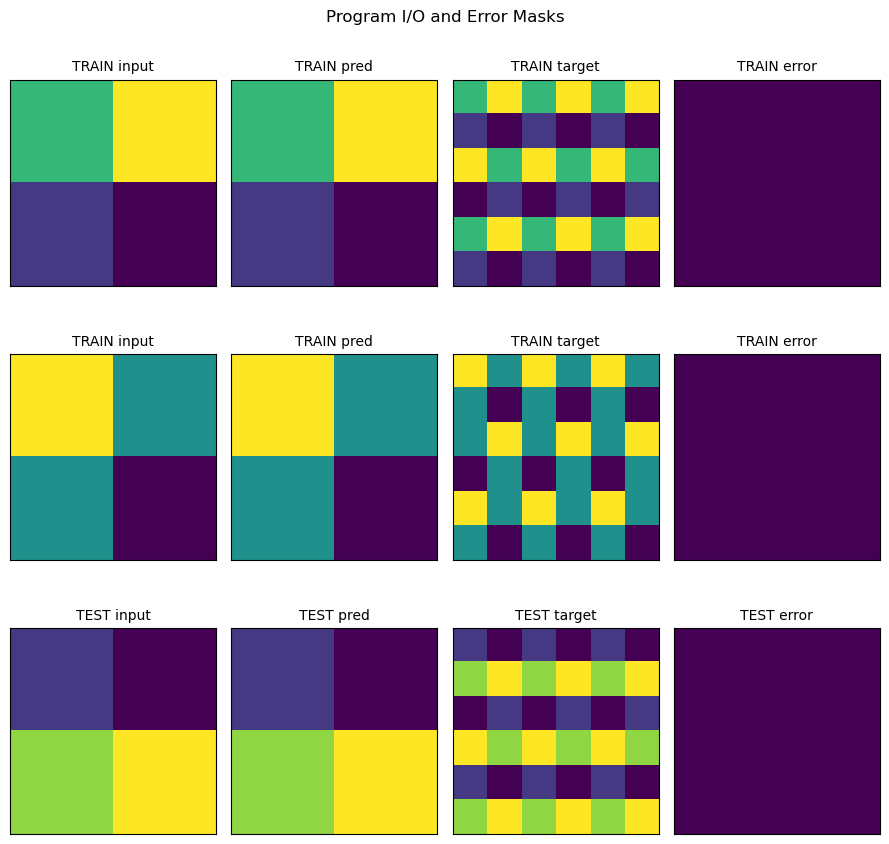


--- FAILED: 007bbfb7.json ---

=== Depth 0 top-6 ===
 1. score= -65.457 :: id
 2. score= -70.504 :: flip_h
 3. score= -70.715 :: rot270
 4. score= -70.730 :: rot90
 5. score= -70.752 :: transpose
 6. score= -70.770 :: rot180

=== Depth 1 top-6 ===
 1. score= -76.994 :: compose2(id, id)
 2. score= -78.593 :: branch_shape(id, id)
 3. score= -82.041 :: compose2(id, flip_h)
 4. score= -82.041 :: compose2(flip_h, id)
 5. score= -82.252 :: compose2(id, rot270)
 6. score= -82.252 :: compose2(rot270, id)

=== Depth 2 top-6 ===
 1. score=-100.069 :: compose2(compose2(id, id), compose2(id, id))
 2. score=-101.668 :: compose2(compose2(id, id), branch_shape(id, id))
 3. score=-101.668 :: compose2(branch_shape(id, id), compose2(id, id))
 4. score=-101.668 :: branch_shape(compose2(id, id), compose2(id, id))
 5. score=-103.266 :: compose2(branch_shape(id, id), branch_shape(id, id))
 6. score=-103.266 :: branch_shape(compose2(id, id), branch_shape(id, id))

=== Depth 3 top-6 ===
 1. score=-146.217 ::

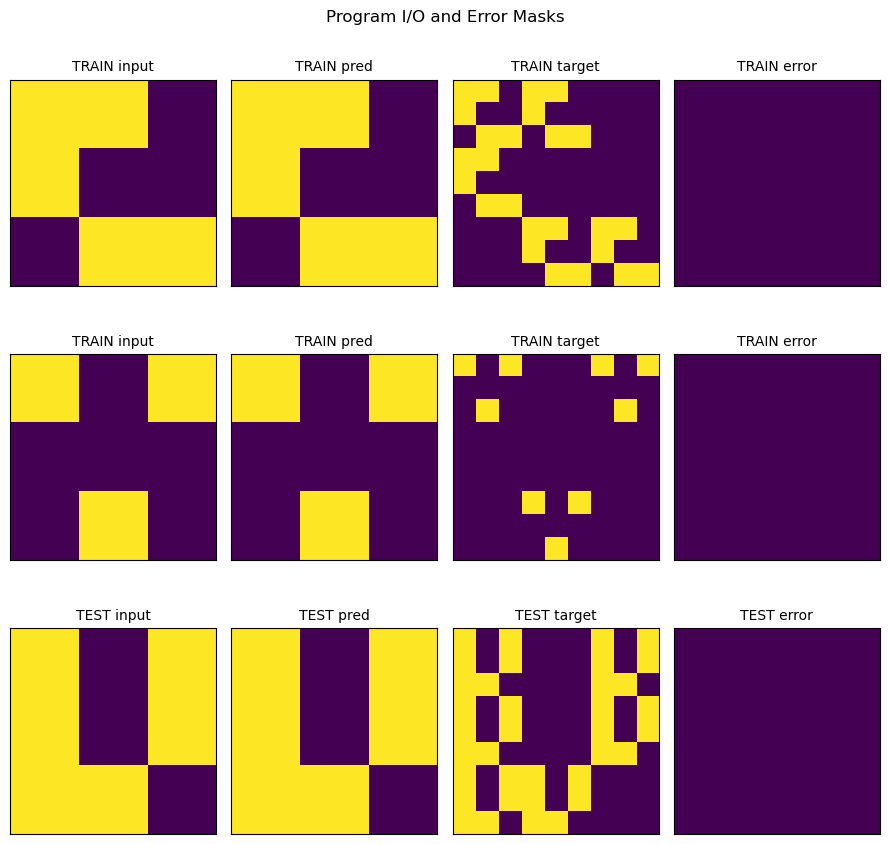


--- FAILED: 009d5c81.json ---

=== Depth 0 top-6 ===
 1. score=  -5.457 :: id
 2. score= -10.509 :: flip_h
 3. score= -10.715 :: rot270
 4. score= -10.731 :: rot90
 5. score= -10.755 :: transpose
 6. score= -10.772 :: rot180

=== Depth 1 top-6 ===
 1. score= -16.993 :: compose2(id, id)
 2. score= -18.594 :: branch_shape(id, id)
 3. score= -22.045 :: compose2(id, flip_h)
 4. score= -22.045 :: compose2(flip_h, id)
 5. score= -22.250 :: compose2(id, rot270)
 6. score= -22.250 :: compose2(rot270, id)

=== Depth 2 top-6 ===
 1. score= -40.064 :: compose2(compose2(id, id), compose2(id, id))
 2. score= -41.665 :: compose2(compose2(id, id), branch_shape(id, id))
 3. score= -41.665 :: compose2(branch_shape(id, id), compose2(id, id))
 4. score= -41.665 :: branch_shape(compose2(id, id), compose2(id, id))
 5. score= -43.266 :: compose2(branch_shape(id, id), branch_shape(id, id))
 6. score= -43.266 :: branch_shape(compose2(id, id), branch_shape(id, id))

=== Depth 3 top-6 ===
 1. score= -86.207 ::

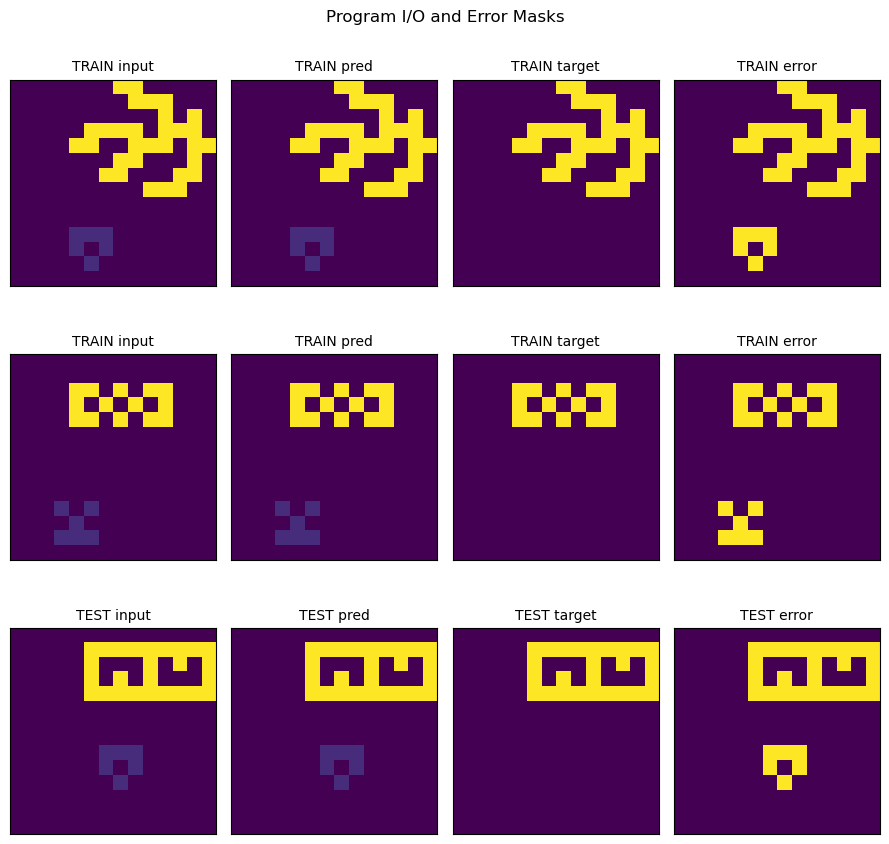

In [ ]:
# 1) Run the debug solver on a single task and inspect search:
name, task = train_tasks[0]   # pick any task you like
P, trace = wake_search_debug(task, BASE_LIBRARY, rec, **search_cfg, topk_view=8)
print("Solved program:", P.pretty() if P else None)
print_trace_table(trace)      # see what the beam focused on at each depth

# 2) If you have a candidate Program (P), visualize where it fails:
if P:
    visualize_program_tree(P)                                      # ASCII tree
    visualize_solution(task, P, max_examples=3)                    # I/O + error masks
    visualize_exec_trace(P, np.array(task["train"][0]["input"]))   # intermediate grids

# 3) Sweep a handful of tasks; show the first N failures with their best frontier:
fail_shown = 0
for name, tjson in train_tasks[:30]:
    P, trace = wake_search_debug(tjson, BASE_LIBRARY, rec, **search_cfg, topk_view=6)
    if P is None:
        print(f"\n--- FAILED: {name} ---")
        print_trace_table(trace)
        # optionally visualize the top-1 candidate to see the exact errors:
        if trace and trace[-1][1]:
            top1 = trace[-1][1][0][2]     # last depth, best program
            visualize_solution(tjson, top1, max_examples=2)
        fail_shown += 1
        if fail_shown >= 3:
            break

In [ ]:
eval_exact, eval_tried, eval_total, avg_acc, avg_mean_d, avg_max_d = solve_and_score(eval_tasks, BASE_LIBRARY)

print(f"Exact solves: {eval_exact}/{eval_total} (among attempted: {eval_exact}/{eval_tried})")
print(f"Average partial solve rate (tile accuracy): {avg_acc:.3f}")
print(f"Average mean abs tile diff: {avg_mean_d:.3f}")
print(f"Average max abs tile diff: {avg_max_d:.3f}")

Exact solves: 0/120 (among attempted: 0/0)
Average partial solve rate (tile accuracy): 0.000
Average mean abs tile diff: 0.000
Average max abs tile diff: 0.000


In [ ]:
def visualize_library_train_solutions(
    tasks,
    lib,
    rec,
    max_solved_tasks=5,
    max_examples_per_task=3,
    topk_view=8,
    show_trace_table=True,
    show_exec_trace=True,
):
    """
    Sweep over training tasks and visualize how the *current library* solves them.

    For each solved task:
      - run wake_search_debug to get program + search trace
      - require exact match on all training examples
      - print the solved program
      - optionally print the search trace table
      - show program tree (visualize_program_tree)
      - show I/O pairs + error masks (visualize_solution)
      - optionally show intermediate grids for first input (visualize_exec_trace)
    """
    solved_shown = 0

    for name, tjson in tasks:
        if solved_shown >= max_solved_tasks:
            break

        # 1) Run debug solver
        P, trace = wake_search_debug(
            tjson,
            lib,
            rec,
            **search_cfg,
            topk_view=topk_view
        )

        if P is None:
            continue  # no program found at all

        # 2) Check that this program truly solves ALL training examples
        all_ok = True
        for ex in tjson["train"]:
            inp = np.array(ex["input"])
            tgt = np.array(ex["output"])
            try:
                pred = P(inp)
            except Exception as e:
                print(f"[{name}] Program raised error on train example: {e}")
                all_ok = False
                break

            if not same_grid(pred, tgt):
                all_ok = False
                break

        if not all_ok:
            continue  # skip partially-solved or buggy programs

        # 3) This is a clean solved task – visualize it
        solved_shown += 1
        print("\n" + "=" * 60)
        print(f"=== SOLVED TRAIN TASK #{solved_shown}: {name} ===")
        print("Solved program:\n", P.pretty() if hasattr(P, "pretty") else P)

        if show_trace_table:
            print("\n--- Search trace (beam frontier by depth) ---")
            print_trace_table(trace)

        # 4) Show program tree structure
        print("\n--- Program tree ---")
        visualize_program_tree(P)

        # 5) Show how it acts on training examples
        print("\n--- Training examples: input | prediction | target ---")
        visualize_solution(tjson, P, max_examples=max_examples_per_task)

        # 6) Optionally show intermediate execution trace for first train input
        if show_exec_trace and tjson["train"]:
            first_inp = np.array(tjson["train"][0]["input"])
            print("\n--- Execution trace on first train input ---")
            visualize_exec_trace(P, first_inp)

    if solved_shown == 0:
        print("No fully-solved training tasks found with the current library + search settings.")
    else:
        print(f"\nDisplayed {solved_shown} solved training tasks.")



=== SOLVED TRAIN TASK #1: 3c9b0459.json ===
Solved program:
 rot180

--- Program tree ---
rot180

--- Training examples: input | prediction | target ---


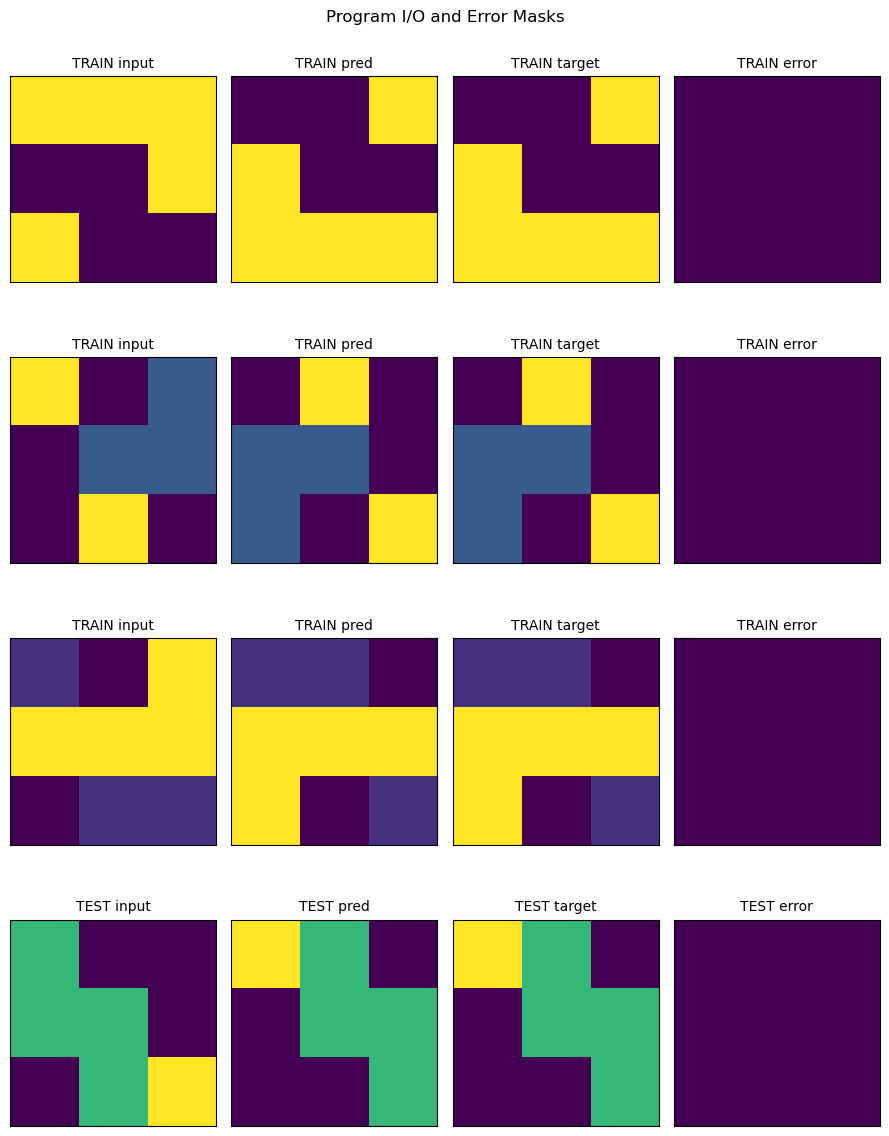


=== SOLVED TRAIN TASK #2: 6150a2bd.json ===
Solved program:
 rot180

--- Program tree ---
rot180

--- Training examples: input | prediction | target ---


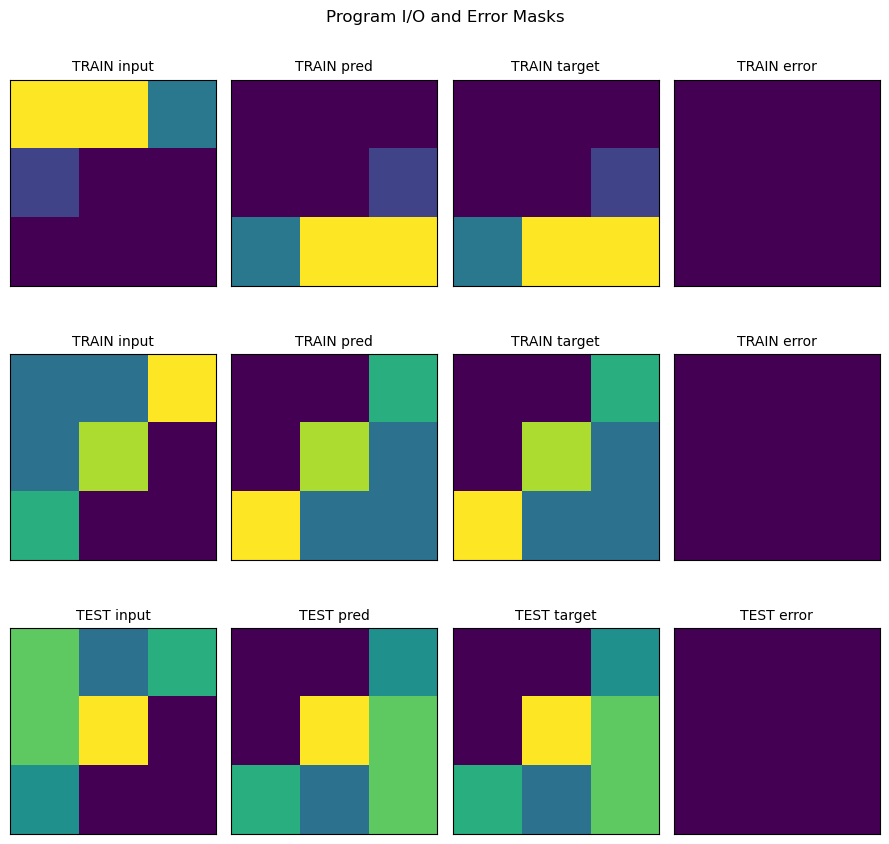


=== SOLVED TRAIN TASK #3: 67a3c6ac.json ===
Solved program:
 flip_h

--- Program tree ---
flip_h

--- Training examples: input | prediction | target ---


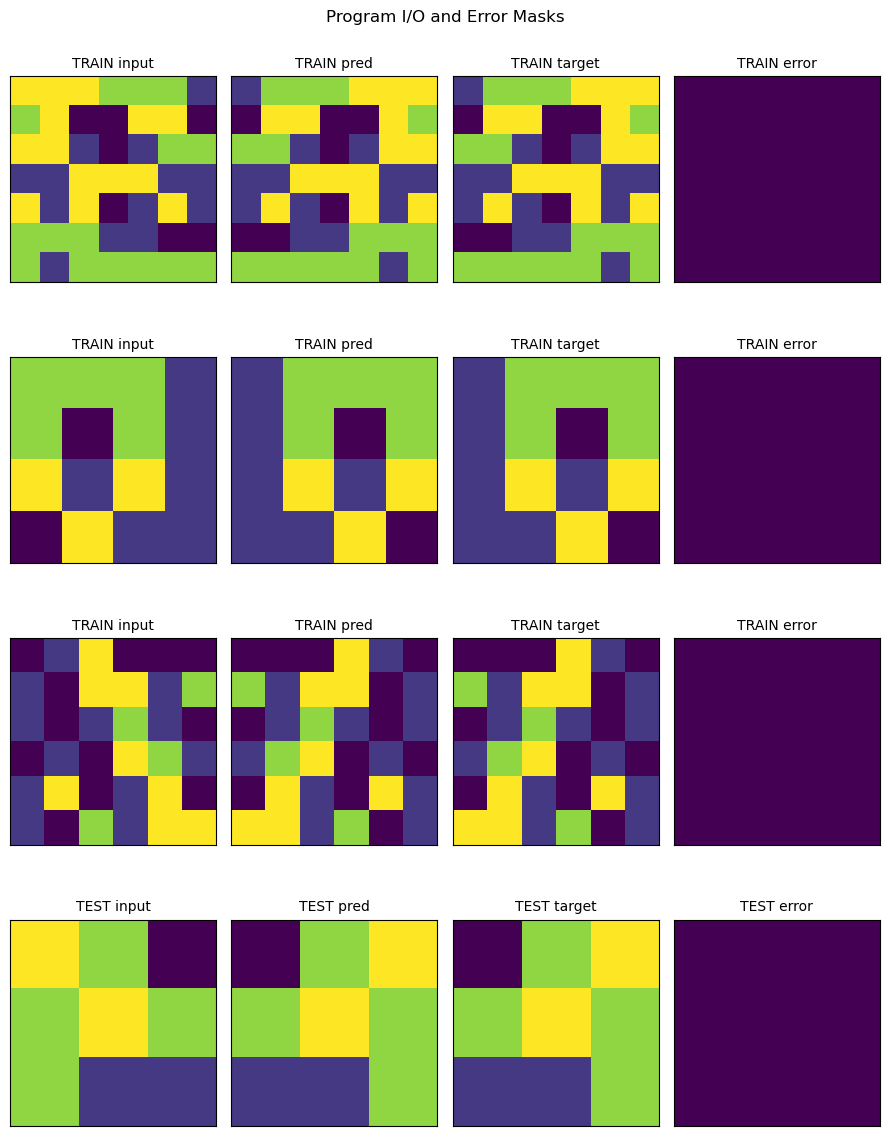


=== SOLVED TRAIN TASK #4: 68b16354.json ===
Solved program:
 flip_v

--- Program tree ---
flip_v

--- Training examples: input | prediction | target ---


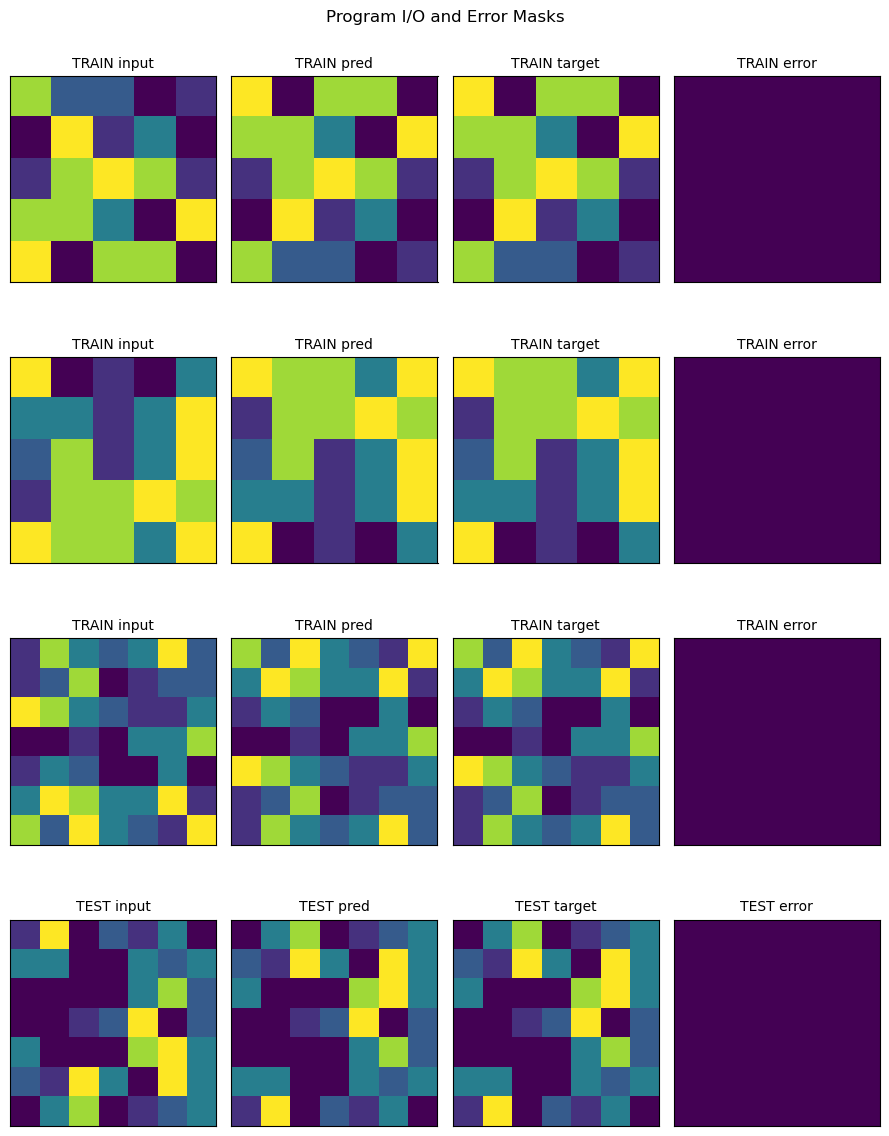


=== SOLVED TRAIN TASK #5: 74dd1130.json ===
Solved program:
 transpose

--- Program tree ---
transpose

--- Training examples: input | prediction | target ---


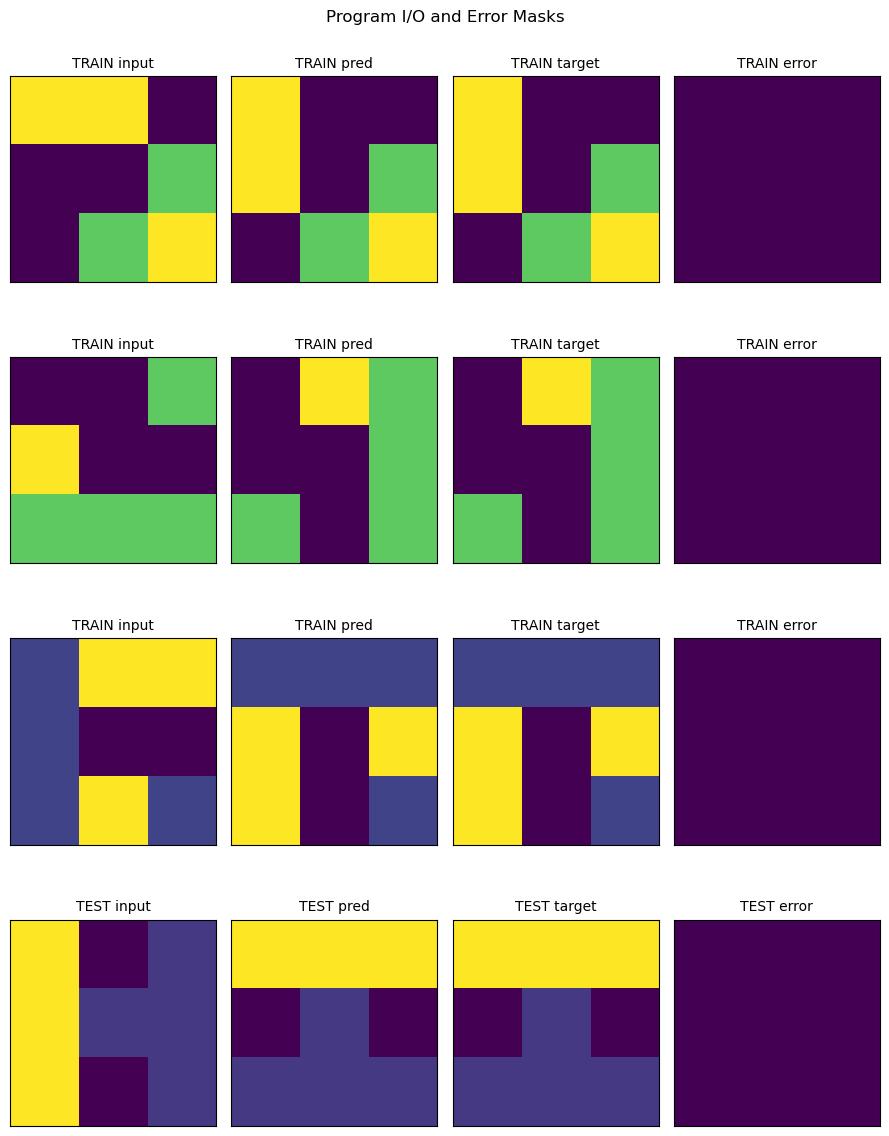


Displayed 5 solved training tasks.


In [ ]:
# Example: inspect how the current BASE_LIBRARY solves some training tasks
visualize_library_train_solutions(
    tasks=train_tasks,
    lib=BASE_LIBRARY,
    rec=rec,                  # your TinyTaskEncoder / recognizer
    max_solved_tasks=5,
    max_examples_per_task=3,
    topk_view=8,
    show_trace_table=False,
    show_exec_trace=False,
)